Ordinary Differential Equations - ODE
====================
or 'How to Model the Zombie Apocalypse'
---------------------------------------------
Jens Hahn - 01/12/2015

Content taken from:      
**Scipy Docs** at http://scipy-cookbook.readthedocs.org/items/Zombie_Apocalypse_ODEINT.html      
Munz *et al.* (2009): http://mysite.science.uottawa.ca/rsmith43/Zombies.pdf

Introduction
=======
What is an ODE
----------------
Differential equations can be used to describe the time-dependent behaviour of a variable.      
$$\frac{\text{d}\vec{x}}{\text{d}t} = f(\vec{x}, t)$$   
In our case the variable stands for the number of humans in a infected (zombies) or not infected population.
Of course they can also be used to describe the change of concentrations in a cell or other continuous or quasi-continuous quantity.     

In general, a first order ODE has two parts, the increasing (birth, formation,...) and the decreasing (death, degradation, ...) part:

$$\frac{\text{d}\vec{x}}{\text{d}t} = \sum_{}\text{Rates}_{\text{production}} - \sum_{}\text{Rates}_{\text{loss}}$$ 


You probably already know ways to solve a differential equation algebraically by 'separation of variables' (Trennung der Variablen) in the homogeneous case or 'variation of parameters' (Variation der Konstanten) in the inhomogeneous case. Here, we want to discuss the use of numerical methods to solve your ODE system.

Numerical integration
------------------------
In principle, every numerical procedure to solve an ODE is based on the so-called "Euler" method. It's very easy to understand, you just have to read the $\frac{\text{d}\vec{x}}{\text{d}t}$ as a $\frac{\Delta \vec{x}}{\Delta t}$. Then you can multiply both sides of the equation with $\Delta t$ and you have an equation describing the change of your variables during a certain time intervall $\Delta t$:

$$ \Delta \vec{x} = f(\vec{x}, t)\times \Delta t$$

Of course, the smaller yoy choose the time intervall $\Delta t$, the more accurate your result will be in comparison to the analytical solution.     
So it's clear, we chose a tiny one, right? Well, not exactly, the smaller your time intervall the longer the simulation will take. Therefore, we need a compromise and here the provided software will help us by constantly testing and observing the numerical solution and adapt the "step size" $\Delta t$ automatically.

Solve the model
==========
The zombie apokalypse model
-------------------------
Let's have a look at our equations:

Number of susceptible victims $S$:
$$\frac{\text{d}S}{\text{d}t} = \text{P} - \text{B}\times S \times Z - \text{d}\times S$$

Number of zombies $Z$:
$$\frac{\text{d}Z}{\text{d}t} = \text{B}\times S \times Z + \text{G}\times R - \text{A}\times S \times Z$$

Number of people "killed" $R$:
$$\frac{\text{d}R}{\text{d}t} = \text{d}\times S + \text{A}\times S \times Z - \text{G}\times R$$

Parameters:     
P: the population birth rate      
d: the chance of a natural death      
B: the chance the “zombie disease” is transmitted (an alive person becomes a zombie)      
G: the chance a dead person is resurrected into a zombie      
A: the chance a zombie is totally destroyed by a human      

Let's start
------------
Before we start the simulation of our model, we have to define our system.     
We start with our static information:
1. Initial conditions for our variables
2. Values of the paramters
3. Simulation time 
4. Number of time points at which we want to have the values for our variables (the time grid). *Use numpy!!*

In [6]:
import numpy as np
# 1. initial conditions
S0 = 500.                   # initial population
Z0 = 0                      # initial zombie population
R0 = 0                      # initial death population
y0 = [S0, Z0, R0]           # initial condition vector

# 2. parameter values
P = 0       # birth rate
d = 0.0001  # 'natural' death percent (per day)
B = 0.0095  # transmission percent  (per day)
G = 0.0001  # resurect percent (per day)
A = 0.001  # destroy percent  (per day)

# 3. simulation time
start = 0.0  # days
end = 15.     # days
number_time_points = 1000.
t  = np.linspace(start, end, number_time_points)  # time grid, 1000 steps or data points

In the second step, we write a small function **f**, that receives a list of the current values of our variables **x** and the current time **t**. The function has to evaluate the equations of our system or $\frac{\text{d}\vec{x}}{\text{d}t}$, respectively. Afterwards, it returns the values of the equations as another list.     
**Important**   
*Since this function **f** is used by the solver, we are not allowed to change the input (arguments) or output (return value) of this function.*

In [7]:
# function 'f' to solve the system dy/dt = f(y, t)
def f(y, t):
    Si = y[0]
    Zi = y[1]
    Ri = y[2]
    # the model equations (see Munz et al. 2009)
    f0 = P - B*Si*Zi - d*Si
    f1 = B*Si*Zi + G*Ri - A*Si*Zi
    f2 = d*Si + A*Si*Zi - G*Ri
    return [f0, f1, f2]

Last but not least, we need to import and call our solver. The result will be a matrix with our time courses as columns and the values at the specified time points. Since we have a values for every time point and every species, we can directly plot the results using *matplotlib*. 

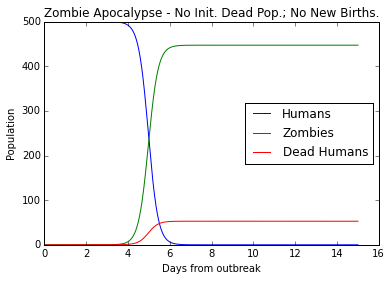

In [8]:
# zombie apocalypse modeling
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint

# solve the DEs
result = odeint(f, y0, t)
S = result[:, 0]
Z = result[:, 1]
R = result[:, 2]

# plot results
plt.figure()
plt.plot(t, S, label='Humans')
plt.plot(t, Z, label='Zombies')
plt.plot(t, R, label='Dead Humans')
plt.xlabel('Days from outbreak')
plt.ylabel('Population')
plt.title('Zombie Apocalypse - No Init. Dead Pop.; No New Births.')
plt.ylim([0,500])
plt.legend(loc=0)

ODEs to describe biochemical reactions
------------------------------------------
When you want to simulate biochemical reactions it is in principle not different to the things you've learned right now, but there is one important thing to consider. People have thought a lot about the best ways to describe certain kinds of chemical reactions and their kinetics. Let's have a look at one of the 'rates' from above:
We wrote the birth rate of humans as $$v_{\text{birth}} = \text{P}$$
that means, there is a constant addition of human beeings in our system, or a constant 'influx'.

Then, we have the 'natural' death of humans $$v_{\text{death}} = \text{d}\times S$$  
The extent of the rate is dependent on the current number of humans S, makes sense, right? The more human beeings there are, the more can die of 'natural' cause.    
Finally, there is the killing of zombies, this rate is not only dependent on the number of zombies Z (the more there are, the more can be killed), but also on the number of humans S, the more there are, the more can kill zombies:
$$v_{\text{kill}} = \text{A}\times S \times Z$$

This kind of 'rate law' we call **mass action**, there is always a parameter multiplied by one or more variables.     

The other very important kinetic rate law is the **Michaelis-Menten** kinetic, you've probably heard about it. This rate law was made for describing an enzymatic reactions, when the rate itself cannot reach unlimited extent. The velocity or flux is limited by the maximal rate of the enzyme:
$$v_{\text{MM}} = \text{V}_\text{max}\times \frac{S}{\text{K}_{\text{m}} + S}$$

Assignments
======
1. Discussion
---------------
* What are the characteristics of an ODE system, can you find possible applications?
* When you look at our zombie example, what shortcomings can you find?

2. Simulate the Lotka-Volterra model (predator - prey model)
----------------------
*Equations:* $$\frac{\text{d}R}{\text{d}t} = \alpha\times R - \beta\times R \times F$$
$$\frac{\text{d}F}{\text{d}t} = -\gamma\times F + \delta\times\beta\times R \times F$$

*Parameters:*     
$\alpha$: natural growing rate of rabbits, when there's no fox around     
$\beta$: natural dying rate of rabbits, due to predation     
$\gamma$: natural dying rate of fox, when there's no rabbit     
$\delta$: factor describing how many caught rabbits let create a new fox  

------------------------------------------------------------------------------------------

**a)** Find a reasonable parameter set     
**b)** Plot the time courses using *matplotlib*     
**c)** Plot the phase plot (What is a phase plot?)     

3. Simulate the chemical reaction system below
--------------------------------
a) Use Michaelis-Menten kinetics to simulate this short reaction chain:
$$\text{A} \longrightarrow \text{B} \longrightarrow \text{C}$$
* Find a reasonable parameter set
* Plot the time courses
b) Use *mass action* kinetics as rate law for the reactions below.
<img src="reacsys.png">
* Find a reasonable parameter set
* Plot the time courses

Literature:
=======
1. L. Grüne & O. Junge - **Gewöhnliche Differentialgleichungen** - Vieweg+Teubner - 2009
2. E. Hairer *et al.* - **Solving Ordinary Differential Equations I** - Springer - 2008
3. E. Klipp *et al.* - **Systems Biology**: A Textbook - Wiley-Blackwell - 2009
4. B. Ingalls - **Mathematical Modeling in Systems Biology**: An Introduction - MIT Press - 2013
4. M. Covert - **Fundamentals of Systems Biology** - CRC Press - 2015
6. H. Sauro - **Systems Biology**: Introduction to Pathway Modeling - Ambrosius Publishing - 2014

